# **Method 2: Personalised Client Selection**

This method implements personalized client selection by dynamically adjusting selection probabilities to prioritize underperforming clients based on their probabilty, using the formula 1 - accuracy.

In [ ]:
!pip install flwr
!pip install torch
!pip install matplotlib

In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

In [ ]:
# Import necessary Libraries
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use "cuda" if GPU is available
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()


Training on cpu
Flower 1.14.0 / PyTorch 2.5.1+cu121


Training on cpu
Flower 1.14.0 / PyTorch 2.5.1+cu121


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


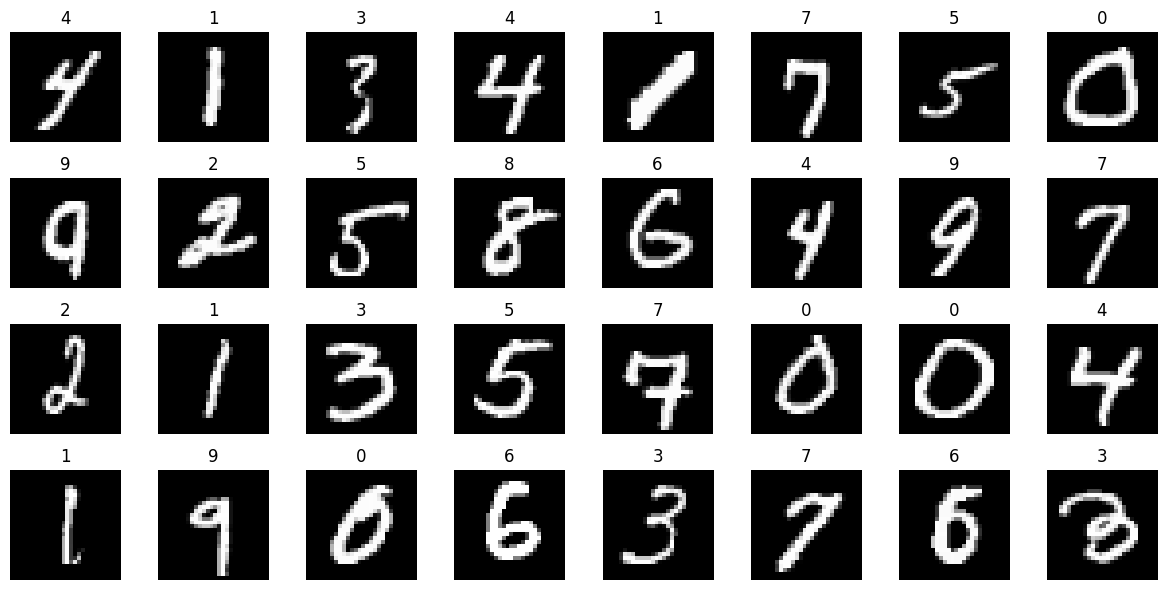

In [ ]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()
NUM_CLIENTS = 10
BATCH_SIZE = 32

#Data Preprocessing
def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="mnist", partitioners={"train": NUM_CLIENTS})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]     # Apply transformations for MNIST
    )

    def apply_transforms(batch):

        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    # Create train/val for each partition
    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloader, valloader, testloader

trainloader, _, _ = load_datasets(partition_id=0)
batch = next(iter(trainloader))
images, labels = batch["image"], batch["label"]

# Reshape and convert images to a NumPy array
images = images.numpy()

# Denormalize the images
images = images * 0.3081 + 0.1307

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i][0], cmap="gray")
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

fig.tight_layout()
plt.show()


In [ ]:
# CNN Model for MNIST
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Training function
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:

            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

# Testing function
def test(net, testloader):

    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:

            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
trainloader, valloader, testloader = load_datasets(partition_id=0)
net = Net().to(DEVICE)

for epoch in range(3):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.010079519152641296, accuracy 0.8941666666666667
Epoch 2: validation loss 0.005310629368759692, accuracy 0.9491666666666667
Epoch 3: validation loss 0.004261408485472202, accuracy 0.9616666666666667
Final test set performance:
	loss 0.004453734173858539
	accuracy 0.9561


In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        # Return the accuracy in the metrics
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
# Client Function for FL
def client_fn(cid: str) -> Client:

    # Load model
    net = Net().to(DEVICE)

    # Use client ID as partition ID
    partition_id = int(cid)
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)


    return FlowerClient(net, trainloader, valloader)


In [ ]:
# To store accuracy of clints
client_accuracies = {}

In [ ]:

from flwr.common import FitIns, Parameters
from flwr.server.client_proxy import ClientProxy

In [ ]:
from flwr.server.client_proxy import ClientProxy

In [ ]:
# Main Strategy
import random
import numpy as np
from typing import List, Tuple, Dict, Optional

from collections import OrderedDict
import flwr as fl
from flwr.server.strategy import FedAvg

from flwr.server.client_manager import ClientManager
from flwr.common import FitRes, EvaluateRes

class CustomFed(FedAvg):
    def __init__(self,
                 max_clients_per_round: int,
                 initial_clients: int,
                 **kwargs):

        super().__init__(**kwargs)
        self.max_clients_per_round = max_clients_per_round
        self.initial_clients = initial_clients
        self.client_accuracies: Dict[str, float] = {}
        self.metrics_distributed = {"accuracy": []}
        self.per_round_client_accuracies: List[Tuple[int, Dict[str, float]]] = []

    def configure_fit(
        self,
        server_round: int,
        parameters: Parameters,
        client_manager: ClientManager,
    ) -> List[Tuple[ClientProxy, FitIns]]:
        available_clients = list(client_manager.all().values())

        if server_round == 1:
            # First round: select initial_clients
            selected_clients = random.sample(available_clients, self.initial_clients)
            print(f"Round {server_round}: Initial selection - {[client.cid for client in selected_clients]}")
        else:
            # Subsequent rounds: select max_clients_per_round based on accuracies
            client_ids = [client.cid for client in available_clients]
            accuracies = np.array([self.client_accuracies.get(cid, 0.0) for cid in client_ids])

            # Assign higher probabilities to clients with lower accuracies
            probabilities = 1.0 - accuracies
            total_prob = probabilities.sum()
            if total_prob == 0:
                # All clients have perfect accuracy; select randomly
                probabilities = np.ones_like(probabilities) / len(probabilities)
            else:
                probabilities /= total_prob  # Normalize to sum to 1

            # Select clients based on the computed probabilities
            selected_indices = np.random.choice(
                len(available_clients),
                size=min(self.max_clients_per_round, len(available_clients)),
                replace=False,
                p=probabilities,
            )
            selected_clients = [available_clients[i] for i in selected_indices]
            print(f"Round {server_round}: Selected clients - {[client.cid for client in selected_clients]}")
            print(f"Round {server_round}: Selection probabilities {dict(zip(client_ids, probabilities.round(3)))}")

        # Create fit instructions
        config = {}
        fit_ins = FitIns(parameters, config)
        return [(client, fit_ins) for client in selected_clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[BaseException],
    ) -> Optional[float]:

        client_accuracies_round = {}
        for client_proxy, evaluate_res in results:
            cid = client_proxy.cid
            accuracy = evaluate_res.metrics.get("accuracy", 0.0)
            self.client_accuracies[cid] = accuracy
            client_accuracies_round[cid] = accuracy

        # Log client accuracies
        print(f"Round {server_round} client accuracies:")
        for cid, acc in client_accuracies_round.items():
            print(f"  Client {cid}: {acc:.4f}")

        # Store global accuracy for plotting
        aggregated_metrics = self.weighted_average([
            (evaluate_res.num_examples, evaluate_res.metrics)
            for _, evaluate_res in results
        ])
        global_accuracy = aggregated_metrics["accuracy"]
        self.metrics_distributed["accuracy"].append((server_round, global_accuracy))

        # Log global accuracy
        print(f"Round {server_round} aggregated accuracy: {global_accuracy:.4f}")

        # Proceed with default aggregation
        return super().aggregate_evaluate(server_round, results, failures)

    @staticmethod
    def weighted_average(metrics: List[Tuple[int, Dict[str, float]]]) -> Dict[str, float]:
        # Calculate weighted average of accuracy
        accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
        examples = [num_examples for num_examples, _ in metrics]
        if sum(examples) == 0:
            return {"accuracy": 0.0}
        return {"accuracy": sum(accuracies) / sum(examples)}


In [ ]:
# Parameters
NUM_CLIENTS = 10
NUM_ROUNDS = 20
INITIAL_CLIENTS = 10       # Number of clients in the first round
MAX_CLIENTS_PER_ROUND = 5  # Number of clients in subsequent rounds

# Initialize the custom strategy
strat = CustomFed(
    initial_clients=INITIAL_CLIENTS,
    max_clients_per_round=MAX_CLIENTS_PER_ROUND,
    fraction_fit=None,        # Manual selection handled within CustomFed
    min_fit_clients=MAX_CLIENTS_PER_ROUND,  # Ensure required number of clients
    min_available_clients=NUM_CLIENTS,
)


In [ ]:
# Create a ServerConfig with the number of rounds
server_config = fl.server.ServerConfig(num_rounds=NUM_ROUNDS)

# Start the simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    client_resources={"num_gpus": 1 if torch.cuda.is_available() else 0},
    config=server_config,
    strategy=strat,
)


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=20, no round_timeout
2024-12-26 08:39:09,493	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 4004039884.0, 'memory': 8008079771.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
<ipython-input-23-c9769143fb03>:5: UserWarning: No `num_cpus` specified in `client_resources`. Using `num_cpus=1` for each client.
  history = fl.s

Round 1: Initial selection - ['16800537607476151116', '5650989757484181522', '2819175903924990632', '9330282846555084089', '11572508004430142440', '7165041849677031996', '3615775992141268427', '8561531322882519238', '14784749820984213330', '13921844410905768427']


(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=21119) 
(ClientAppActor pid=21119)             This is a deprecated feature. It will be removed
(ClientAppActor pid=21119)             entirely in future versions of Flower.
(ClientAppActor pid=21119)         
(ClientAppActor pid=21117) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=21117) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=21117) see the appropriate new directories, set the environment variable
(ClientAppActor pid=21117) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=21117) The use of platformdir

Round 1 client accuracies:
  Client 14784749820984213330: 0.9158
  Client 16800537607476151116: 0.9100
  Client 5650989757484181522: 0.9158
  Client 9330282846555084089: 0.9175
  Client 2819175903924990632: 0.9033
  Client 13921844410905768427: 0.9100
  Client 8561531322882519238: 0.9192
  Client 3615775992141268427: 0.9058
  Client 11572508004430142440: 0.9092
  Client 7165041849677031996: 0.9367
Round 1 aggregated accuracy: 0.9143
Round 2: Selected clients - ['5650989757484181522', '11572508004430142440', '16800537607476151116', '14784749820984213330', '9330282846555084089']
Round 2: Selection probabilities {'14784749820984213330': 0.098, '8561531322882519238': 0.094, '9330282846555084089': 0.096, '13921844410905768427': 0.105, '5650989757484181522': 0.098, '11572508004430142440': 0.106, '16800537607476151116': 0.105, '3615775992141268427': 0.11, '2819175903924990632': 0.113, '7165041849677031996': 0.074}


(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=21117)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=21117)          [repeated 12x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21119)             This is a deprecated feature. It will be removed [repeated 2x

Round 2 client accuracies:
  Client 14784749820984213330: 0.9542
  Client 8561531322882519238: 0.9508
  Client 11572508004430142440: 0.9558
  Client 16800537607476151116: 0.9417
  Client 13921844410905768427: 0.9475
  Client 7165041849677031996: 0.9617
  Client 5650989757484181522: 0.9558
  Client 3615775992141268427: 0.9383
  Client 2819175903924990632: 0.9492
  Client 9330282846555084089: 0.9550
Round 2 aggregated accuracy: 0.9510
Round 3: Selected clients - ['2819175903924990632', '3615775992141268427', '8561531322882519238', '7165041849677031996', '14784749820984213330']
Round 3: Selection probabilities {'14784749820984213330': 0.094, '8561531322882519238': 0.1, '9330282846555084089': 0.092, '13921844410905768427': 0.107, '5650989757484181522': 0.09, '11572508004430142440': 0.09, '16800537607476151116': 0.119, '3615775992141268427': 0.126, '2819175903924990632': 0.104, '7165041849677031996': 0.078}


(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=21117)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=21117)          [repeated 12x across cluster]
(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 2x

Round 3 client accuracies:
  Client 11572508004430142440: 0.9742
  Client 5650989757484181522: 0.9692
  Client 2819175903924990632: 0.9642
  Client 8561531322882519238: 0.9642
  Client 16800537607476151116: 0.9525
  Client 13921844410905768427: 0.9625
  Client 3615775992141268427: 0.9508
  Client 14784749820984213330: 0.9608
  Client 9330282846555084089: 0.9667
  Client 7165041849677031996: 0.9733
Round 3 aggregated accuracy: 0.9638
Round 4: Selected clients - ['3615775992141268427', '2819175903924990632', '8561531322882519238', '5650989757484181522', '16800537607476151116']
Round 4: Selection probabilities {'14784749820984213330': 0.108, '8561531322882519238': 0.099, '9330282846555084089': 0.092, '13921844410905768427': 0.104, '5650989757484181522': 0.085, '11572508004430142440': 0.071, '16800537607476151116': 0.131, '3615775992141268427': 0.136, '2819175903924990632': 0.099, '7165041849677031996': 0.074}


(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=21117)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=21117)          [repeated 8x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21119)             This is a deprecated feature. It will be removed [repeated 2x 

Round 4 client accuracies:
  Client 7165041849677031996: 0.9725
  Client 3615775992141268427: 0.9600
  Client 14784749820984213330: 0.9725
  Client 13921844410905768427: 0.9675
  Client 8561531322882519238: 0.9708
  Client 9330282846555084089: 0.9733
  Client 11572508004430142440: 0.9750
  Client 2819175903924990632: 0.9683
  Client 5650989757484181522: 0.9683
  Client 16800537607476151116: 0.9617
Round 4 aggregated accuracy: 0.9690
Round 5: Selected clients - ['14784749820984213330', '7165041849677031996', '2819175903924990632', '8561531322882519238', '3615775992141268427']
Round 5: Selection probabilities {'14784749820984213330': 0.089, '8561531322882519238': 0.094, '9330282846555084089': 0.086, '13921844410905768427': 0.105, '5650989757484181522': 0.102, '11572508004430142440': 0.081, '16800537607476151116': 0.124, '3615775992141268427': 0.129, '2819175903924990632': 0.102, '7165041849677031996': 0.089}


(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=21117)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=21117)          [repeated 8x across cluster]
(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 2x 

Round 5 client accuracies:
  Client 16800537607476151116: 0.9658
  Client 2819175903924990632: 0.9775
  Client 5650989757484181522: 0.9733
  Client 14784749820984213330: 0.9783
  Client 11572508004430142440: 0.9783
  Client 13921844410905768427: 0.9733
  Client 8561531322882519238: 0.9775
  Client 9330282846555084089: 0.9800
  Client 7165041849677031996: 0.9767
  Client 3615775992141268427: 0.9633
Round 5 aggregated accuracy: 0.9744
Round 6: Selected clients - ['8561531322882519238', '2819175903924990632', '9330282846555084089', '3615775992141268427', '13921844410905768427']
Round 6: Selection probabilities {'14784749820984213330': 0.085, '8561531322882519238': 0.088, '9330282846555084089': 0.078, '13921844410905768427': 0.104, '5650989757484181522': 0.104, '11572508004430142440': 0.085, '16800537607476151116': 0.134, '3615775992141268427': 0.143, '2819175903924990632': 0.088, '7165041849677031996': 0.091}


(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=21117)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=21117)          [repeated 8x across cluster]
(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 2x 

Round 6 client accuracies:
  Client 8561531322882519238: 0.9800
  Client 3615775992141268427: 0.9700
  Client 11572508004430142440: 0.9808
  Client 13921844410905768427: 0.9758
  Client 16800537607476151116: 0.9683
  Client 5650989757484181522: 0.9742
  Client 7165041849677031996: 0.9783
  Client 14784749820984213330: 0.9775
  Client 2819175903924990632: 0.9767
  Client 9330282846555084089: 0.9825
Round 6 aggregated accuracy: 0.9764
Round 7: Selected clients - ['11572508004430142440', '13921844410905768427', '3615775992141268427', '14784749820984213330', '5650989757484181522']
Round 7: Selection probabilities {'14784749820984213330': 0.095, '8561531322882519238': 0.085, '9330282846555084089': 0.074, '13921844410905768427': 0.102, '5650989757484181522': 0.11, '11572508004430142440': 0.081, '16800537607476151116': 0.134, '3615775992141268427': 0.127, '2819175903924990632': 0.099, '7165041849677031996': 0.092}


(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=21119)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=21119)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=21119)          [repeated 8x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21119)             This is a deprecated feature. It will be removed [repeated 2x 

Round 7 client accuracies:
  Client 7165041849677031996: 0.9808
  Client 2819175903924990632: 0.9792
  Client 13921844410905768427: 0.9792
  Client 9330282846555084089: 0.9817
  Client 3615775992141268427: 0.9742
  Client 5650989757484181522: 0.9767
  Client 8561531322882519238: 0.9758
  Client 11572508004430142440: 0.9833
  Client 14784749820984213330: 0.9783
  Client 16800537607476151116: 0.9725
Round 7 aggregated accuracy: 0.9782
Round 8: Selected clients - ['14784749820984213330', '3615775992141268427', '7165041849677031996', '2819175903924990632', '8561531322882519238']
Round 8: Selection probabilities {'14784749820984213330': 0.099, '8561531322882519238': 0.111, '9330282846555084089': 0.084, '13921844410905768427': 0.095, '5650989757484181522': 0.107, '11572508004430142440': 0.076, '16800537607476151116': 0.126, '3615775992141268427': 0.118, '2819175903924990632': 0.095, '7165041849677031996': 0.088}


(ClientAppActor pid=21119)          [repeated 4x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21119)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=21119)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=21119)          [repeated 4x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21119)          

Round 8 client accuracies:
  Client 13921844410905768427: 0.9792
  Client 11572508004430142440: 0.9875
  Client 9330282846555084089: 0.9833
  Client 3615775992141268427: 0.9733
  Client 14784749820984213330: 0.9825
  Client 2819175903924990632: 0.9792
  Client 8561531322882519238: 0.9808
  Client 16800537607476151116: 0.9733
  Client 7165041849677031996: 0.9825
  Client 5650989757484181522: 0.9742
Round 8 aggregated accuracy: 0.9796
Round 9: Selected clients - ['5650989757484181522', '7165041849677031996', '9330282846555084089', '16800537607476151116', '13921844410905768427']
Round 9: Selection probabilities {'14784749820984213330': 0.086, '8561531322882519238': 0.094, '9330282846555084089': 0.082, '13921844410905768427': 0.102, '5650989757484181522': 0.127, '11572508004430142440': 0.061, '16800537607476151116': 0.131, '3615775992141268427': 0.131, '2819175903924990632': 0.102, '7165041849677031996': 0.086}


(ClientAppActor pid=21117)          [repeated 8x across cluster]
(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=21117)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=21117)          [repeated 4x across cluster]
(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21117)          

Round 9 client accuracies:
  Client 13921844410905768427: 0.9767
  Client 9330282846555084089: 0.9858
  Client 3615775992141268427: 0.9758
  Client 7165041849677031996: 0.9808
  Client 8561531322882519238: 0.9808
  Client 16800537607476151116: 0.9750
  Client 2819175903924990632: 0.9792
  Client 14784749820984213330: 0.9817
  Client 5650989757484181522: 0.9783
  Client 11572508004430142440: 0.9875
Round 9 aggregated accuracy: 0.9802
Round 10: Selected clients - ['8561531322882519238', '14784749820984213330', '7165041849677031996', '16800537607476151116', '3615775992141268427']
Round 10: Selection probabilities {'14784749820984213330': 0.092, '8561531322882519238': 0.097, '9330282846555084089': 0.071, '13921844410905768427': 0.118, '5650989757484181522': 0.109, '11572508004430142440': 0.063, '16800537607476151116': 0.126, '3615775992141268427': 0.122, '2819175903924990632': 0.105, '7165041849677031996': 0.097}


(ClientAppActor pid=21117)          [repeated 12x across cluster]
(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=21117)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=21117)          [repeated 4x across cluster]
(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21117)         

Round 10 client accuracies:
  Client 5650989757484181522: 0.9792
  Client 7165041849677031996: 0.9833
  Client 13921844410905768427: 0.9842
  Client 3615775992141268427: 0.9758
  Client 2819175903924990632: 0.9825
  Client 11572508004430142440: 0.9883
  Client 9330282846555084089: 0.9892
  Client 8561531322882519238: 0.9817
  Client 14784749820984213330: 0.9842
  Client 16800537607476151116: 0.9758
Round 10 aggregated accuracy: 0.9824
Round 11: Selected clients - ['13921844410905768427', '7165041849677031996', '8561531322882519238', '16800537607476151116', '11572508004430142440']
Round 11: Selection probabilities {'14784749820984213330': 0.09, '8561531322882519238': 0.104, '9330282846555084089': 0.062, '13921844410905768427': 0.09, '5650989757484181522': 0.118, '11572508004430142440': 0.066, '16800537607476151116': 0.137, '3615775992141268427': 0.137, '2819175903924990632': 0.1, '7165041849677031996': 0.095}


(ClientAppActor pid=21117)          [repeated 8x across cluster]
(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=21117)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=21119)          [repeated 4x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21119)          

Round 11 client accuracies:
  Client 3615775992141268427: 0.9742
  Client 8561531322882519238: 0.9817
  Client 7165041849677031996: 0.9842
  Client 11572508004430142440: 0.9867
  Client 16800537607476151116: 0.9792
  Client 13921844410905768427: 0.9850
  Client 14784749820984213330: 0.9850
  Client 5650989757484181522: 0.9792
  Client 9330282846555084089: 0.9867
  Client 2819175903924990632: 0.9817
Round 11 aggregated accuracy: 0.9823
Round 12: Selected clients - ['3615775992141268427', '5650989757484181522', '11572508004430142440', '16800537607476151116', '13921844410905768427']
Round 12: Selection probabilities {'14784749820984213330': 0.085, '8561531322882519238': 0.104, '9330282846555084089': 0.075, '13921844410905768427': 0.085, '5650989757484181522': 0.118, '11572508004430142440': 0.075, '16800537607476151116': 0.118, '3615775992141268427': 0.146, '2819175903924990632': 0.104, '7165041849677031996': 0.09}


(ClientAppActor pid=21119)          [repeated 8x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=21119)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=21119)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=21119)          [repeated 4x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21119)          

Round 12 client accuracies:
  Client 3615775992141268427: 0.9808
  Client 7165041849677031996: 0.9875
  Client 13921844410905768427: 0.9800
  Client 5650989757484181522: 0.9792
  Client 14784749820984213330: 0.9875
  Client 2819175903924990632: 0.9850
  Client 11572508004430142440: 0.9858
  Client 8561531322882519238: 0.9850
  Client 9330282846555084089: 0.9900
  Client 16800537607476151116: 0.9742
Round 12 aggregated accuracy: 0.9835
Round 13: Selected clients - ['9330282846555084089', '3615775992141268427', '16800537607476151116', '11572508004430142440', '8561531322882519238']
Round 13: Selection probabilities {'14784749820984213330': 0.076, '8561531322882519238': 0.091, '9330282846555084089': 0.061, '13921844410905768427': 0.121, '5650989757484181522': 0.126, '11572508004430142440': 0.086, '16800537607476151116': 0.157, '3615775992141268427': 0.116, '2819175903924990632': 0.091, '7165041849677031996': 0.076}


(ClientAppActor pid=21119)          [repeated 8x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=21119)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=21119)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=21119)          [repeated 4x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21119)          

Round 13 client accuracies:
  Client 9330282846555084089: 0.9917
  Client 7165041849677031996: 0.9883
  Client 14784749820984213330: 0.9850
  Client 8561531322882519238: 0.9842
  Client 11572508004430142440: 0.9883
  Client 2819175903924990632: 0.9842
  Client 13921844410905768427: 0.9858
  Client 3615775992141268427: 0.9808
  Client 5650989757484181522: 0.9792
  Client 16800537607476151116: 0.9783
Round 13 aggregated accuracy: 0.9846
Round 14: Selected clients - ['14784749820984213330', '3615775992141268427', '8561531322882519238', '7165041849677031996', '13921844410905768427']
Round 14: Selection probabilities {'14784749820984213330': 0.097, '8561531322882519238': 0.103, '9330282846555084089': 0.054, '13921844410905768427': 0.092, '5650989757484181522': 0.135, '11572508004430142440': 0.076, '16800537607476151116': 0.141, '3615775992141268427': 0.124, '2819175903924990632': 0.103, '7165041849677031996': 0.076}


(ClientAppActor pid=21119)          [repeated 8x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=21119)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=21119)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=21119)          [repeated 4x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21119)          

Round 14 client accuracies:
  Client 7165041849677031996: 0.9867
  Client 14784749820984213330: 0.9875
  Client 11572508004430142440: 0.9900
  Client 2819175903924990632: 0.9833
  Client 9330282846555084089: 0.9900
  Client 16800537607476151116: 0.9783
  Client 5650989757484181522: 0.9783
  Client 13921844410905768427: 0.9858
  Client 8561531322882519238: 0.9817
  Client 3615775992141268427: 0.9867
Round 14 aggregated accuracy: 0.9848
Round 15: Selected clients - ['13921844410905768427', '2819175903924990632', '9330282846555084089', '11572508004430142440', '16800537607476151116']
Round 15: Selection probabilities {'14784749820984213330': 0.082, '8561531322882519238': 0.121, '9330282846555084089': 0.066, '13921844410905768427': 0.093, '5650989757484181522': 0.143, '11572508004430142440': 0.066, '16800537607476151116': 0.143, '3615775992141268427': 0.088, '2819175903924990632': 0.11, '7165041849677031996': 0.088}


(ClientAppActor pid=21117)          [repeated 10x across cluster]
(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=21117)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=21119)          [repeated 4x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21119)         

Round 15 client accuracies:
  Client 14784749820984213330: 0.9867
  Client 16800537607476151116: 0.9783
  Client 3615775992141268427: 0.9858
  Client 2819175903924990632: 0.9858
  Client 7165041849677031996: 0.9883
  Client 13921844410905768427: 0.9800
  Client 5650989757484181522: 0.9792
  Client 11572508004430142440: 0.9900
  Client 9330282846555084089: 0.9908
  Client 8561531322882519238: 0.9867
Round 15 aggregated accuracy: 0.9852
Round 16: Selected clients - ['7165041849677031996', '13921844410905768427', '9330282846555084089', '14784749820984213330', '3615775992141268427']
Round 16: Selection probabilities {'14784749820984213330': 0.09, '8561531322882519238': 0.09, '9330282846555084089': 0.062, '13921844410905768427': 0.135, '5650989757484181522': 0.14, '11572508004430142440': 0.067, '16800537607476151116': 0.146, '3615775992141268427': 0.096, '2819175903924990632': 0.096, '7165041849677031996': 0.079}


(ClientAppActor pid=21117)          [repeated 8x across cluster]
(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=21117)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=21119)          [repeated 4x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21119)          

Round 16 client accuracies:
  Client 14784749820984213330: 0.9883
  Client 9330282846555084089: 0.9925
  Client 7165041849677031996: 0.9875
  Client 16800537607476151116: 0.9808
  Client 8561531322882519238: 0.9842
  Client 2819175903924990632: 0.9842
  Client 3615775992141268427: 0.9850
  Client 13921844410905768427: 0.9808
  Client 11572508004430142440: 0.9892
  Client 5650989757484181522: 0.9817
Round 16 aggregated accuracy: 0.9854
Round 17: Selected clients - ['2819175903924990632', '5650989757484181522', '11572508004430142440', '7165041849677031996', '8561531322882519238']
Round 17: Selection probabilities {'14784749820984213330': 0.08, '8561531322882519238': 0.109, '9330282846555084089': 0.051, '13921844410905768427': 0.131, '5650989757484181522': 0.126, '11572508004430142440': 0.074, '16800537607476151116': 0.131, '3615775992141268427': 0.103, '2819175903924990632': 0.109, '7165041849677031996': 0.086}


(ClientAppActor pid=21117)          [repeated 8x across cluster]
(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=21117)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=21119)          [repeated 4x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21119)          

Round 17 client accuracies:
  Client 13921844410905768427: 0.9842
  Client 3615775992141268427: 0.9850
  Client 7165041849677031996: 0.9883
  Client 8561531322882519238: 0.9858
  Client 2819175903924990632: 0.9875
  Client 5650989757484181522: 0.9800
  Client 16800537607476151116: 0.9808
  Client 11572508004430142440: 0.9942
  Client 14784749820984213330: 0.9892
  Client 9330282846555084089: 0.9925
Round 17 aggregated accuracy: 0.9868
Round 18: Selected clients - ['8561531322882519238', '9330282846555084089', '5650989757484181522', '16800537607476151116', '14784749820984213330']
Round 18: Selection probabilities {'14784749820984213330': 0.082, '8561531322882519238': 0.107, '9330282846555084089': 0.057, '13921844410905768427': 0.119, '5650989757484181522': 0.151, '11572508004430142440': 0.044, '16800537607476151116': 0.145, '3615775992141268427': 0.113, '2819175903924990632': 0.094, '7165041849677031996': 0.088}


(ClientAppActor pid=21119)          [repeated 8x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=21119)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=21119)             entirely in future versions of Flower. [repeated 4x across cluster]
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=21117)          [repeated 6x across cluster]
(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You ca

Round 18 client accuracies:
  Client 3615775992141268427: 0.9817
  Client 7165041849677031996: 0.9883
  Client 16800537607476151116: 0.9825
  Client 14784749820984213330: 0.9908
  Client 8561531322882519238: 0.9867
  Client 11572508004430142440: 0.9892
  Client 2819175903924990632: 0.9867
  Client 13921844410905768427: 0.9800
  Client 9330282846555084089: 0.9925
  Client 5650989757484181522: 0.9808
Round 18 aggregated accuracy: 0.9859
Round 19: Selected clients - ['8561531322882519238', '14784749820984213330', '3615775992141268427', '7165041849677031996', '16800537607476151116']
Round 19: Selection probabilities {'14784749820984213330': 0.065, '8561531322882519238': 0.095, '9330282846555084089': 0.053, '13921844410905768427': 0.142, '5650989757484181522': 0.136, '11572508004430142440': 0.077, '16800537607476151116': 0.124, '3615775992141268427': 0.13, '2819175903924990632': 0.095, '7165041849677031996': 0.083}


(ClientAppActor pid=21119)          [repeated 12x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=21119)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=21119)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=21119)          [repeated 4x across cluster]
(ClientAppActor pid=21119) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21119)         

Round 19 client accuracies:
  Client 3615775992141268427: 0.9850
  Client 13921844410905768427: 0.9867
  Client 2819175903924990632: 0.9858
  Client 14784749820984213330: 0.9858
  Client 11572508004430142440: 0.9900
  Client 5650989757484181522: 0.9808
  Client 9330282846555084089: 0.9925
  Client 16800537607476151116: 0.9833
  Client 7165041849677031996: 0.9875
  Client 8561531322882519238: 0.9875
Round 19 aggregated accuracy: 0.9865
Round 20: Selected clients - ['3615775992141268427', '2819175903924990632', '5650989757484181522', '7165041849677031996', '14784749820984213330']
Round 20: Selection probabilities {'14784749820984213330': 0.105, '8561531322882519238': 0.093, '9330282846555084089': 0.056, '13921844410905768427': 0.099, '5650989757484181522': 0.142, '11572508004430142440': 0.074, '16800537607476151116': 0.123, '3615775992141268427': 0.111, '2819175903924990632': 0.105, '7165041849677031996': 0.093}


(ClientAppActor pid=21117)          [repeated 12x across cluster]
(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=21117)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=21117)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=21117)          [repeated 4x across cluster]
(ClientAppActor pid=21117) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=21117)         

Round 20 client accuracies:
  Client 16800537607476151116: 0.9833
  Client 9330282846555084089: 0.9908
  Client 7165041849677031996: 0.9858
  Client 3615775992141268427: 0.9858
  Client 5650989757484181522: 0.9792
  Client 2819175903924990632: 0.9867
  Client 8561531322882519238: 0.9867
  Client 14784749820984213330: 0.9875
  Client 13921844410905768427: 0.9842
  Client 11572508004430142440: 0.9875
Round 20 aggregated accuracy: 0.9858


Testing for evaluation

In [ ]:
# Retrieve the final global parameters from the strategy
final_parameters = strat.latest_parameters

# Load the global test set
_, _, testloader = load_datasets(partition_id=0)  # The test set is the same for all

# Define the evaluation function
def evaluate_global_model(global_parameters: Parameters, testloader):

    params = fl.common.parameters_to_ndarrays(global_parameters)

    # Initialize a new model instance
    net = Net().to(DEVICE)

    # Set the model parameters to the global parameters
    set_parameters(net, params)

    # Evaluate on the test set
    loss, accuracy = test(net, testloader)
    return loss, accuracy

# Evaluate the final global model
loss, accuracy = evaluate_global_model(final_parameters, testloader)


print(f"Final test set performance after personalized selection:")
print(f"\tLoss: {loss}")
print(f"\tAccuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Final test set performance after personalized selection:
	Loss: 0.0009712792541671661
	Accuracy: 0.9903


Uniform Client selection to compare with Personalised client selection

In [ ]:
# Fedavg strategy with additional parameters
import flwr as fl
from flwr.server.strategy import FedAvg
from flwr.common import (
    FitIns,
    FitRes,
    EvaluateRes,
    Parameters,
    Scalar,
    Config,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from typing import List, Tuple, Dict, Optional

class FedAvgWithParams(FedAvg):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.latest_parameters: Optional[Parameters] = None  # To store the latest global parameters
        self.metrics_distributed = {"accuracy": []}         # Store global accuracy over rounds

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[BaseException],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)
        if aggregated_parameters is not None:
            # Store the latest global parameters
            self.latest_parameters = aggregated_parameters
        return aggregated_parameters, aggregated_metrics

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[BaseException],
    ) -> Optional[float]:

        metrics = []
        for client_proxy, evaluate_res in results:
            num_examples = evaluate_res.num_examples
            accuracy = evaluate_res.metrics.get("accuracy", 0.0)
            metrics.append((num_examples, {"accuracy": accuracy}))
        # Compute weighted average accuracy
        aggregated_metrics = self.weighted_average(metrics)
        global_accuracy = aggregated_metrics["accuracy"]
        # Store global accuracy for plotting
        self.metrics_distributed["accuracy"].append((server_round, global_accuracy))
        # Log the global accuracy
        print(f"Round {server_round} aggregated accuracy: {global_accuracy}")

        return super().aggregate_evaluate(server_round, results, failures)

    @staticmethod
    def weighted_average(metrics: List[Tuple[int, Dict[str, Scalar]]]) -> Dict[str, Scalar]:
        # Calculate weighted average of accuracy
        accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
        examples = [num_examples for num_examples, _ in metrics]
        if sum(examples) == 0:
            return {"accuracy": 0.0}
        return {"accuracy": sum(accuracies) / sum(examples)}



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

NUM_ROUNDS = 20  # Train the FL model for 20 rounds
LOCAL_EPOCHS = 1  # Number of local epochs per client

# Update the client function to use LOCAL_EPOCHS
def client_fn(cid: str) -> fl.client.Client:
    """Create a Flower client with the given client ID."""
    # Load model
    net = Net().to(DEVICE)


    partition_id = int(cid)
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)


    return FlowerClient(net, trainloader, valloader).to_client()

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config: Config) -> List[np.ndarray]:
        return get_parameters(self.net)

    def fit(self, parameters: List[np.ndarray], config: Config) -> Tuple[List[np.ndarray], int, Dict]:
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=LOCAL_EPOCHS)
        return get_parameters(self.net), len(self.trainloader.dataset), {}

    def evaluate(self, parameters: List[np.ndarray], config: Config) -> Tuple[float, int, Dict]:
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}

# Initialize the standard FedAvg strategy with parameter storage
standard_strategy = FedAvgWithParams(
    fraction_fit=1.0,         # m/N = 5/10 = 0.5
    min_fit_clients=10,        # Ensure at least 5 clients are selected
    min_available_clients=NUM_CLIENTS,
)

# Create a ServerConfig with the number of rounds
server_config = fl.server.ServerConfig(num_rounds=NUM_ROUNDS)

# Start the simulation with the standard strategy
history_standard = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    client_resources={"num_gpus": 1 if torch.cuda.is_available() else 0},
    config=server_config,
    strategy=standard_strategy,
)


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=20, no round_timeout
2024-12-26 08:21:50,173	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 4003128115.0, 'memory': 8006256231.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
<ipython-input-16-8358088e5277>:48: UserWarning: No `num_cpus` specified in `client_resources`. Using `num_cpus=1` for each client.
  history_stand

Round 1 aggregated accuracy: 0.9009166666666667


(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=13168)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=13170) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13170)          [repeated 4x across cluster]
(ClientAppActor pid=13170)          

Round 2 aggregated accuracy: 0.9491666666666667


(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=13168)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)          

Round 3 aggregated accuracy: 0.964


(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=13168)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)          

Round 4 aggregated accuracy: 0.971


(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=13168)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)          

Round 5 aggregated accuracy: 0.975


(ClientAppActor pid=13170) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=13170)          [repeated 12x across cluster]
(ClientAppActor pid=13170)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=13170)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)         

Round 6 aggregated accuracy: 0.9760833333333333


(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=13168)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)          

Round 7 aggregated accuracy: 0.9804166666666667


(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=13168)          [repeated 6x across cluster]
(ClientAppActor pid=13168)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=13168)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=13170) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13170)          [repeated 4x across cluster]
(ClientAppActor pid=13170)          

Round 8 aggregated accuracy: 0.9811666666666666


(ClientAppActor pid=13170) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=13170)          [repeated 12x across cluster]
(ClientAppActor pid=13170)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=13170)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=13170) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13170)          [repeated 4x across cluster]
(ClientAppActor pid=13170)         

Round 9 aggregated accuracy: 0.9831666666666666


(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=13168)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=13170) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13170)          [repeated 4x across cluster]
(ClientAppActor pid=13170)          

Round 10 aggregated accuracy: 0.9838333333333333


(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=13168)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=13170) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13170)          [repeated 4x across cluster]
(ClientAppActor pid=13170)          

Round 11 aggregated accuracy: 0.9836666666666667


(ClientAppActor pid=13170) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=13170)          [repeated 8x across cluster]
(ClientAppActor pid=13170)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=13170)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=13170) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13170)          [repeated 4x across cluster]
(ClientAppActor pid=13170)          

Round 12 aggregated accuracy: 0.9848333333333333


(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=13168)          [repeated 6x across cluster]
(ClientAppActor pid=13168)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=13168)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=13170) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13170)          [repeated 4x across cluster]
(ClientAppActor pid=13170)          

Round 13 aggregated accuracy: 0.9858333333333333


(ClientAppActor pid=13170) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13170)          [repeated 4x across cluster]
(ClientAppActor pid=13170)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=13170)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=13170) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13170)          [repeated 4x across cluster]
(ClientAppActor pid=13170)          

Round 14 aggregated accuracy: 0.9868333333333333


(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=13168)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)          

Round 15 aggregated accuracy: 0.9876666666666667


(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=13168)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)          

Round 16 aggregated accuracy: 0.9875833333333334


(ClientAppActor pid=13170) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13170)          [repeated 4x across cluster]
(ClientAppActor pid=13170)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=13170)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=13170) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13170)          [repeated 4x across cluster]
(ClientAppActor pid=13170)          

Round 17 aggregated accuracy: 0.9874166666666667


(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=13168)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)          

Round 18 aggregated accuracy: 0.9885833333333334


(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=13168)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)          

Round 19 aggregated accuracy: 0.9879166666666667


(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=13168)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=13168) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=13168)          [repeated 4x across cluster]
(ClientAppActor pid=13168)          

Round 20 aggregated accuracy: 0.9884166666666667


Testing for evaluation

In [ ]:
# Retrieve the final global parameters from the standard strategy
final_parameters_standard = standard_strategy.latest_parameters

# Load the global test set
_, _, testloader = load_datasets(partition_id=0)  # The test set is the same for all

# Define the evaluation function if not already defined
def evaluate_global_model(global_parameters: Parameters, testloader):
    # Convert Parameters to a list of NumPy arrays
    params = fl.common.parameters_to_ndarrays(global_parameters)

    # Initialize a new model instance
    net = Net().to(DEVICE)

    # Set the model parameters to the global parameters
    set_parameters(net, params)

    # Evaluate on the test set
    loss, accuracy = test(net, testloader)
    return loss, accuracy

# Evaluate the final global model after uniform selection
loss_standard, accuracy_standard = evaluate_global_model(final_parameters_standard, testloader)


print(f"Final test set performance after uniform selection:")
print(f"\tLoss: {loss_standard}")
print(f"\tAccuracy: {accuracy_standard}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Final test set performance after uniform selection:
	Loss: 0.0010200217825295113
	Accuracy: 0.9897


Visualisation to compare Personalised strategy with Uniform

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


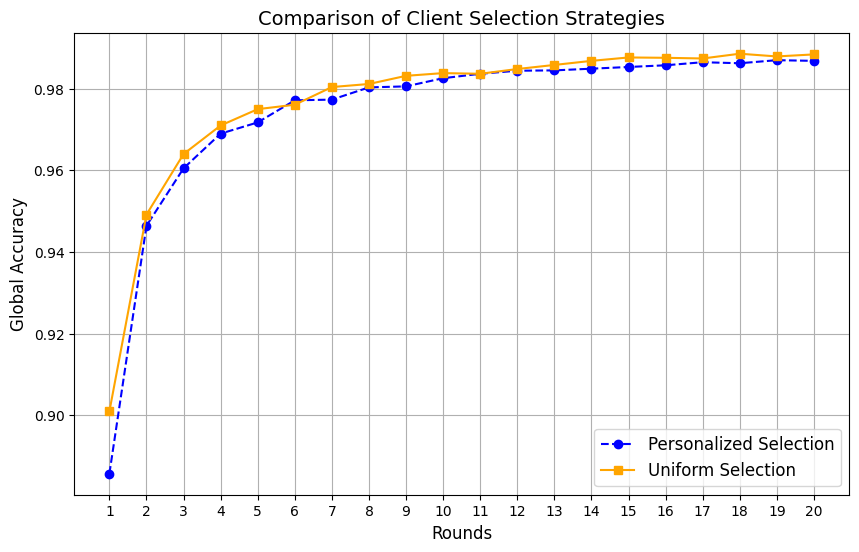

In [ ]:
import matplotlib.pyplot as plt

# Visualization function
def plot_accuracies(personalized_strategy, uniform_strategy):

    # Extract rounds and accuracies from strategies
    personalized_data = personalized_strategy.metrics_distributed["accuracy"]
    uniform_data = uniform_strategy.metrics_distributed["accuracy"]

    if not personalized_data or not uniform_data:
        print("No accuracy data available. Ensure you have run your FL simulations.")
        return

    # Extract rounds and accuracies for both strategies
    personalized_rounds, personalized_accuracies = zip(*personalized_data)
    uniform_rounds, uniform_accuracies = zip(*uniform_data)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(personalized_rounds, personalized_accuracies, label="Personalized Selection", marker='o', linestyle='--', color='blue')
    plt.plot(uniform_rounds, uniform_accuracies, label="Uniform Selection", marker='s', linestyle='-', color='orange')


    plt.title("Comparison of Client Selection Strategies", fontsize=14)
    plt.xlabel("Rounds", fontsize=12)
    plt.ylabel("Global Accuracy", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(range(1, max(personalized_rounds) + 1))
    plt.show()



plot_accuracies(strat, standard_strategy)
